# Time series III

https://cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html

https://skforecast.org/0.13.0/user_guides/autoregresive-forecaster

https://www.geeksforgeeks.org/multioutput-regression-in-machine-learning/

In [87]:
import datetime as dt
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR,LinearSVR


import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.statespace.sarimax import SARIMAX


import warnings
warnings.filterwarnings("ignore")

In [8]:
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size':8})


# Get data 

In [13]:
el2022 = pd.read_csv('data/electricity-production and consumption_2022.csv',  delimiter=';',decimal=',')
el2022['timestamp'] = pd.to_datetime(el2022['Kuupaev (Eesti aeg)'], dayfirst=True)

data = el2022[['timestamp', 'Tarbimine']]
data.set_index('timestamp', inplace=True)
data = data.rename(columns = {'Tarbimine':'Demand'})
data.head()

,Demand
timestamp,
2022-01-01 00:00:00,899.4
2022-01-01 01:00:00,892.1
2022-01-01 02:00:00,874.3
2022-01-01 03:00:00,860.1
2022-01-01 04:00:00,842.7


# Distribution

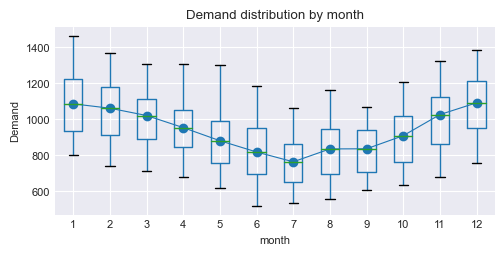

In [14]:
# Demand distribution by month
# ==============================================================================
fig, ax = plt.subplots(figsize=(5.5, 2.5))
data['month'] = data.index.month
data.boxplot(column='Demand', by='month', ax=ax,)
data.groupby('month')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by month')
fig.suptitle('')
plt.show();

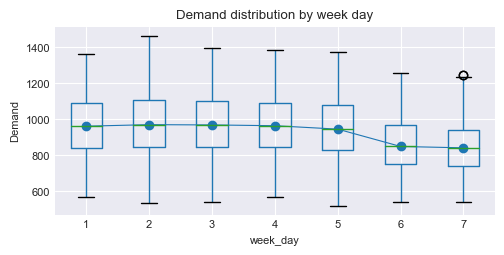

In [15]:
# Demand distribution by week day
# ==============================================================================
fig, ax = plt.subplots(figsize=(5.5, 2.5))
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='Demand', by='week_day', ax=ax)
data.groupby('week_day')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by week day')
fig.suptitle('')
plt.show();

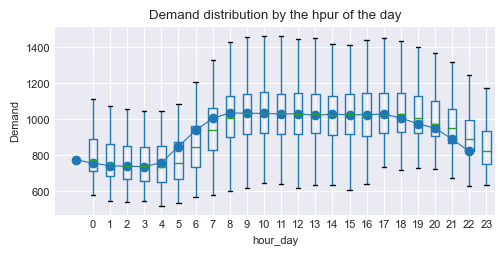

In [51]:
# Demand distribution by the hour of the day
# ==============================================================================
fig, ax = plt.subplots(figsize=(5.5, 2.5))
data['hour_day'] = data.index.hour 
data.boxplot(column='Demand', by='hour_day', ax=ax)
data.groupby('hour_day')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by the hpur of the day')
fig.suptitle('')
plt.show();

# Autocorrelation

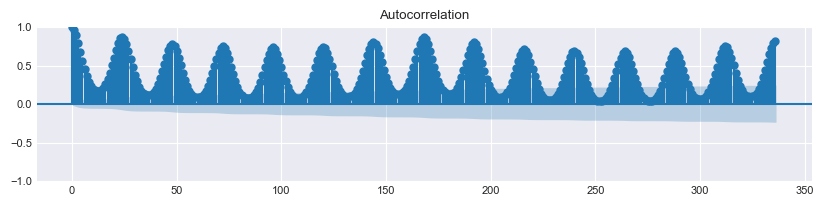

In [20]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 2))
plot_acf(data.Demand, ax=ax, lags=14*24)
plt.show()


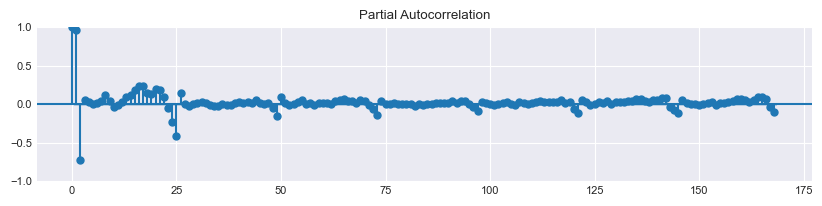

In [22]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 2))
plot_pacf(data.Demand, ax=ax, lags=7*24)
plt.show()

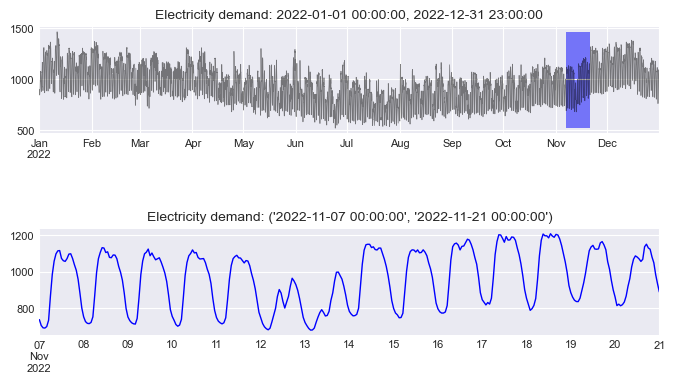

In [29]:
# Zooming time series chart
# ==============================================================================
zoom = ('2022-11-07 00:00:00', '2022-11-21 00:00:00')
fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)
main_ax = fig.add_subplot(grid[:3, :])
data.Demand.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data.Demand)
max_y = max(data.Demand)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_title(f'Electricity demand: {data.index.min()}, {data.index.max()}', fontsize=10)
main_ax.set_xlabel('')
zoom_ax = fig.add_subplot(grid[5:, :])
data.loc[zoom[0]: zoom[1]].Demand.plot(ax=zoom_ax, color='blue', linewidth=1)
zoom_ax.set_title(f'Electricity demand: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)
plt.show();

# Baseline. Seasonal Naive Forecasting

In [54]:
baseline = data[['Demand']].copy()
baseline['lag_24_7'] = baseline['Demand'].shift(24*7)
baseline['lag_24'] = baseline['Demand'].shift(24)

baseline.tail(48)

,Demand,lag_24_7,lag_24
timestamp,,,
2022-12-30 00:00:00,876.8,864.2,885.9
2022-12-30 01:00:00,840.8,835.3,850.6
2022-12-30 02:00:00,824.1,822.2,827.3
2022-12-30 03:00:00,807.8,818.9,819.8
2022-12-30 04:00:00,802.5,822.6,821.5
2022-12-30 05:00:00,820.9,845.4,870.7
2022-12-30 06:00:00,874.2,895.0,924.7
2022-12-30 07:00:00,942.2,981.4,995.0
2022-12-30 08:00:00,1018.6,1069.7,1080.3


MAPE: 1.552


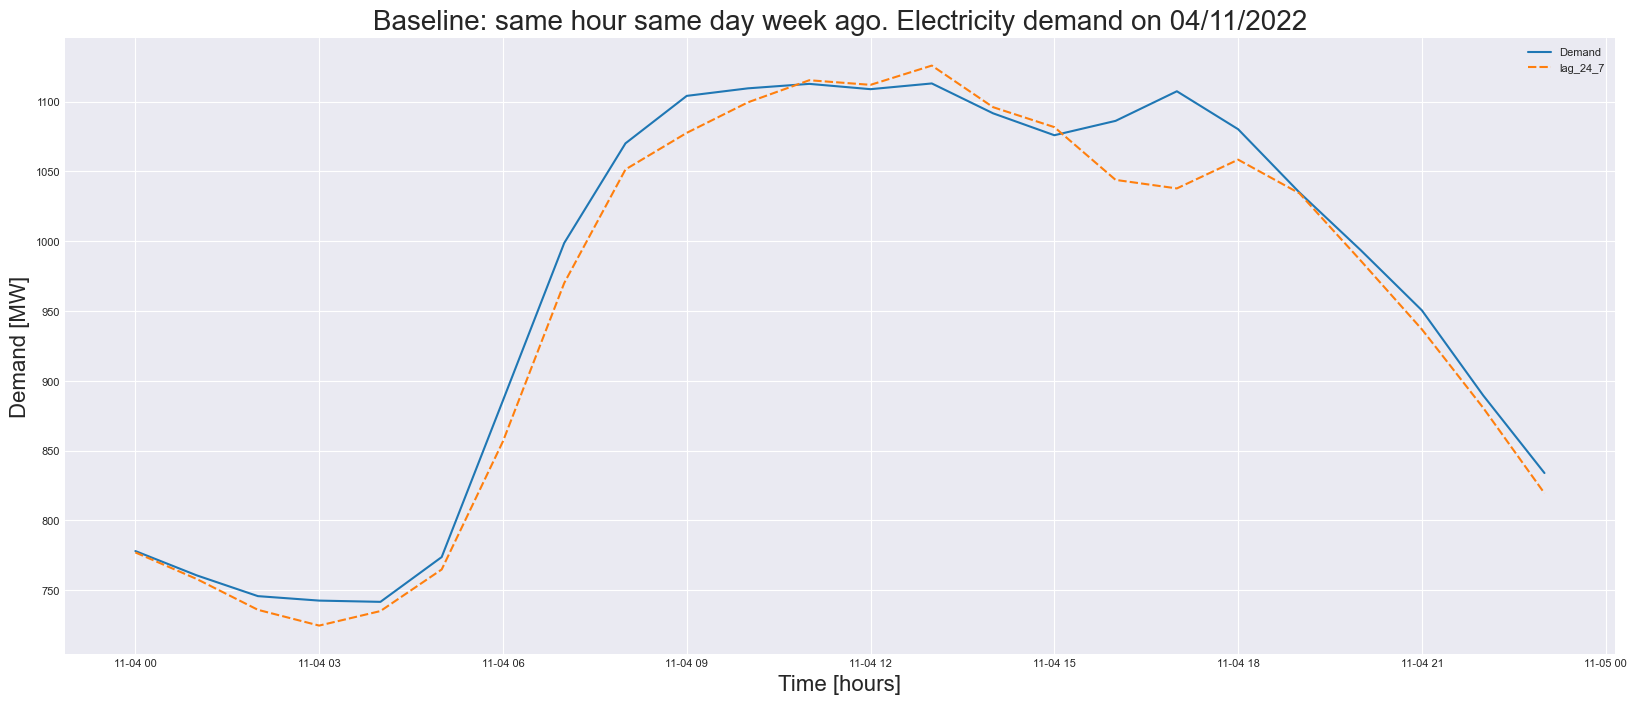

In [55]:
predict_for_start = datetime.datetime(2022,11,4)
predict_for_end = predict_for_start + datetime.timedelta(days = 1)

testing_vector = baseline[(baseline.index >= predict_for_start) &  (baseline.index < predict_for_end)]

plt.figure(figsize=(20,8))
plt.title(predict_for_start.date())
p = sns.lineplot(data = testing_vector[['Demand','lag_24_7']]);
plt.title("Baseline: same hour same day week ago. Electricity demand on 04/11/2022", fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Demand [MW]", fontsize = 16);

print("MAPE: %.3f" % (mean_absolute_percentage_error(testing_vector['Demand'], testing_vector['lag_24_7'])*100))

MAPE: 0.894


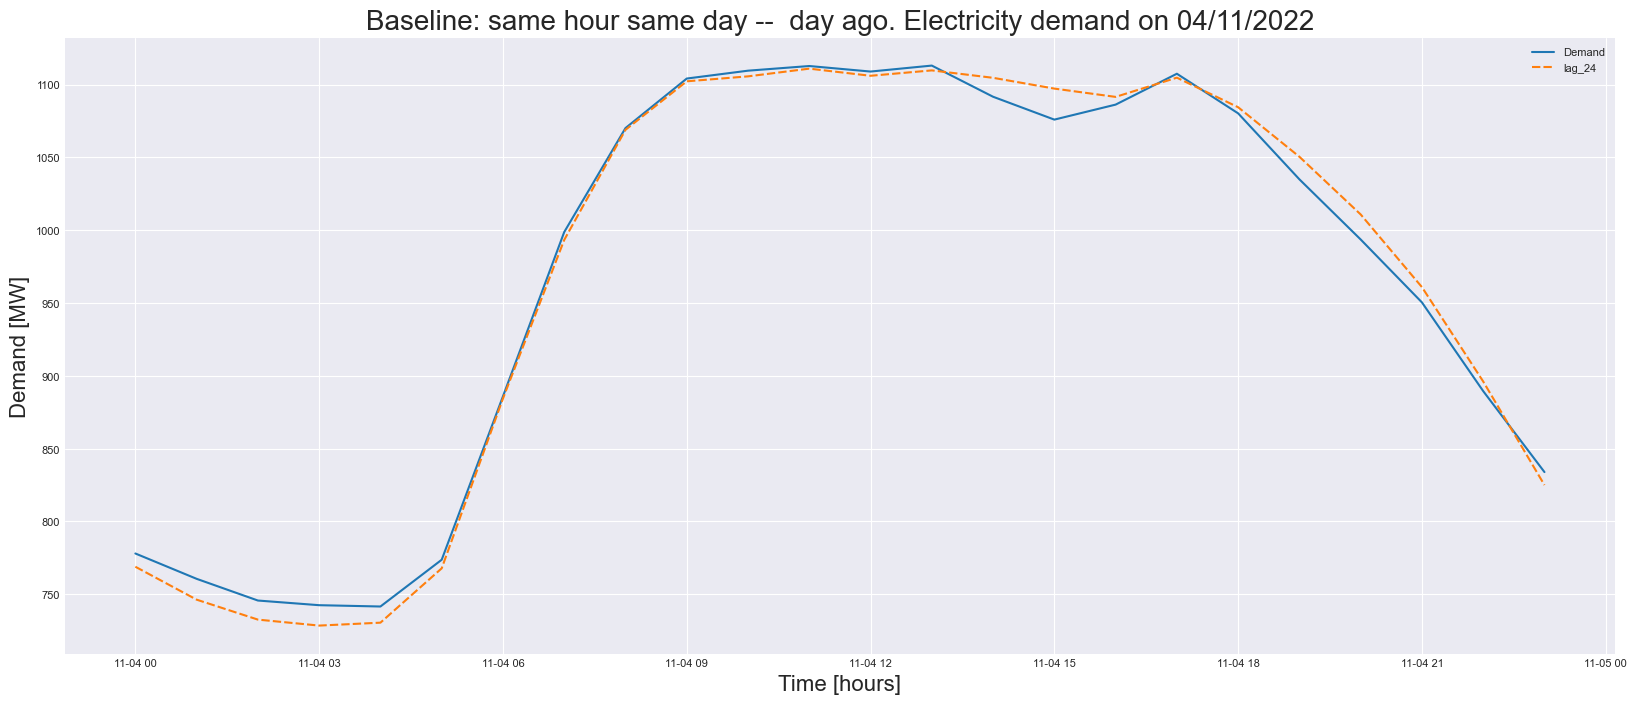

In [56]:
plt.figure(figsize=(20,8))
plt.title(predict_for_start.date())
p = sns.lineplot(data = testing_vector[['Demand','lag_24']]);
plt.title("Baseline: same hour same day --  day ago. Electricity demand on 04/11/2022", fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Demand [MW]", fontsize = 16);

print("MAPE: %.3f" % (mean_absolute_percentage_error(testing_vector['Demand'], testing_vector['lag_24'])*100))

# One-step-ahead

MAPE: 1.021


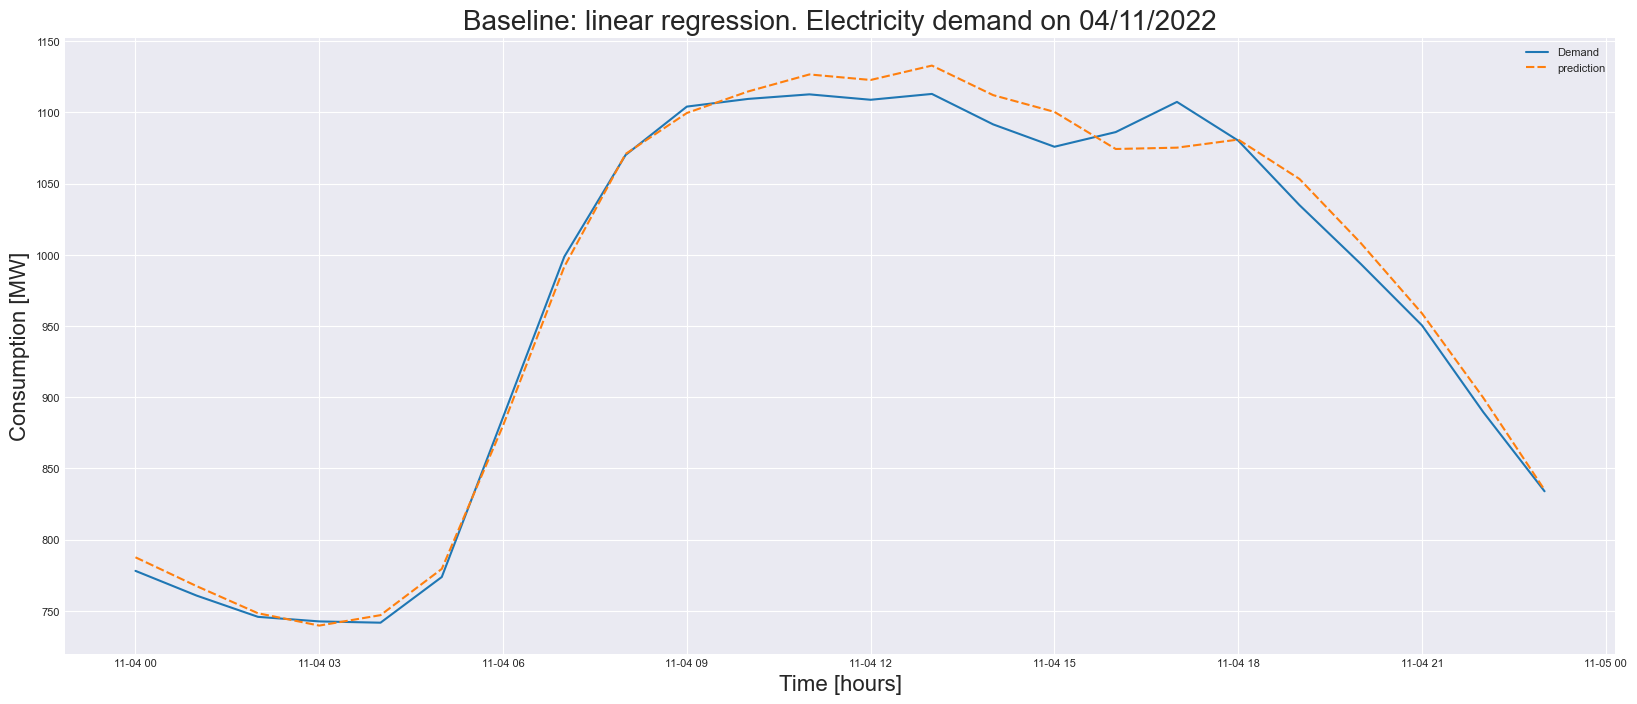

In [151]:
predict_for_start = datetime.datetime(2022,11,4)
predict_for_end = predict_for_start + datetime.timedelta(days = 1)

training_end = predict_for_start - datetime.timedelta(days = 1)
training_start = training_end - datetime.timedelta(days = 30)

testing_vector = baseline[(baseline.index >= predict_for_start) &  (baseline.index < predict_for_end)]
training_vector = baseline[(baseline.index >= training_start) &  (baseline.index < training_end)]

X_test = testing_vector[['lag_24', 'lag_24_7']]
y_test = testing_vector[['Demand']]

X_train = training_vector[['lag_24', 'lag_24_7']]
y_train = training_vector[['Demand']]

model = LinearRegression()
model.fit(X_train,y_train)

predictions_vector =  pd.DataFrame(model.predict(X_test))
predictions_vector.set_index(y_test.index, inplace=True)
predictions_vector = predictions_vector.rename(columns = {0:'prediction'})

plt.figure(figsize=(20,8))
plt.title(predict_for_start.date())
p = sns.lineplot(data = y_test.join(predictions_vector));
plt.title("Baseline: linear regression. Electricity demand on 04/11/2022", fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Consumption [MW]", fontsize = 16);

print("MAPE: %.3f" % (mean_absolute_percentage_error(y_test, predictions_vector)*100))

# Multi-step-ahead forecast. Direct

In [105]:
direct = data[['Demand','hour_day']].copy()
idx_positions = np.arange(len(direct))

for x in range(1,25):
    cname = "lag_" + str(x)
    shifted_idx_positions = idx_positions - (direct["hour_day"]+x)
    shifted_loc_index = direct.index[shifted_idx_positions]
    direct[cname] = direct.loc[shifted_loc_index, "Demand"].values

direct.tail(48)

,Demand,hour_day,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-12-30 00:00:00,876.8,0,919.6,977.8,1031.4,1077.0,1105.1,1142.3,1167.5,1175.1,...,1113.0,1080.3,995.0,924.7,870.7,821.5,819.8,827.3,850.6,885.9
2022-12-30 01:00:00,840.8,1,919.6,977.8,1031.4,1077.0,1105.1,1142.3,1167.5,1175.1,...,1113.0,1080.3,995.0,924.7,870.7,821.5,819.8,827.3,850.6,885.9
2022-12-30 02:00:00,824.1,2,919.6,977.8,1031.4,1077.0,1105.1,1142.3,1167.5,1175.1,...,1113.0,1080.3,995.0,924.7,870.7,821.5,819.8,827.3,850.6,885.9
2022-12-30 03:00:00,807.8,3,919.6,977.8,1031.4,1077.0,1105.1,1142.3,1167.5,1175.1,...,1113.0,1080.3,995.0,924.7,870.7,821.5,819.8,827.3,850.6,885.9
2022-12-30 04:00:00,802.5,4,919.6,977.8,1031.4,1077.0,1105.1,1142.3,1167.5,1175.1,...,1113.0,1080.3,995.0,924.7,870.7,821.5,819.8,827.3,850.6,885.9
2022-12-30 05:00:00,820.9,5,919.6,977.8,1031.4,1077.0,1105.1,1142.3,1167.5,1175.1,...,1113.0,1080.3,995.0,924.7,870.7,821.5,819.8,827.3,850.6,885.9
2022-12-30 06:00:00,874.2,6,919.6,977.8,1031.4,1077.0,1105.1,1142.3,1167.5,1175.1,...,1113.0,1080.3,995.0,924.7,870.7,821.5,819.8,827.3,850.6,885.9
2022-12-30 07:00:00,942.2,7,919.6,977.8,1031.4,1077.0,1105.1,1142.3,1167.5,1175.1,...,1113.0,1080.3,995.0,924.7,870.7,821.5,819.8,827.3,850.6,885.9
2022-12-30 08:00:00,1018.6,8,919.6,977.8,1031.4,1077.0,1105.1,1142.3,1167.5,1175.1,...,1113.0,1080.3,995.0,924.7,870.7,821.5,819.8,827.3,850.6,885.9


In [111]:
direct.loc[direct.hour_day==0]

,Demand,hour_day,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-01,899.4,0,817.6,846.5,889.5,932.5,989.4,1042.8,1085.3,1091.7,...,922.4,880.8,834.3,797.5,766.6,760.8,758.8,770.9,787.6,834.0
2022-01-02,936.6,0,967.6,997.3,1030.9,1052.8,1064.3,1076.5,1069.1,1052.0,...,882.0,874.8,868.4,852.2,844.7,842.7,860.1,874.3,892.1,899.4
2022-01-03,923.0,0,964.9,1020.5,1073.9,1116.1,1140.5,1159.6,1164.5,1158.9,...,1013.3,983.2,933.6,900.3,878.2,883.9,891.8,899.7,917.2,936.6
2022-01-04,929.3,0,985.8,1068.0,1139.7,1196.0,1227.4,1262.2,1280.7,1309.2,...,1263.7,1227.8,1119.5,1010.0,909.4,902.0,886.2,905.1,923.7,923.0
2022-01-05,923.6,0,973.9,1046.7,1121.4,1167.9,1211.1,1242.4,1260.7,1266.4,...,1204.8,1183.4,1075.3,978.0,893.4,869.5,865.0,884.8,910.3,929.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,924.8,0,965.5,1013.4,1064.2,1100.6,1124.6,1144.7,1159.3,1154.8,...,1039.8,995.9,944.0,900.7,859.1,833.0,825.7,836.9,851.5,871.5
2022-12-28,872.7,0,902.2,973.0,1033.4,1084.0,1113.8,1143.2,1169.8,1182.3,...,1184.4,1155.1,1065.1,981.7,913.5,887.3,886.8,890.7,907.1,924.8
2022-12-29,885.9,0,927.6,981.4,1045.1,1095.1,1124.6,1164.6,1168.5,1179.6,...,1110.8,1078.1,987.4,905.8,844.5,825.3,824.7,830.9,848.3,872.7


In [133]:
predict_for_start = datetime.datetime(2022,11,4)
predict_for_end = predict_for_start + datetime.timedelta(days = 1)

training_end = predict_for_start - datetime.timedelta(days = 1)
training_start = training_end - datetime.timedelta(days = 30)

testing_vector = direct[(direct.index >= predict_for_start) &  (direct.index < predict_for_end)]
training_vector = direct[(direct.index >= training_start) &  (direct.index < training_end)]

In [116]:
X_test = testing_vector.loc[direct.hour_day==0]
X_test = X_test .loc[:, ~X_test.columns.isin(['hour_day', 'Demand'])]

y_test = testing_vector[['Demand']].loc[direct.hour_day==0]

X_train = training_vector.loc[direct.hour_day==0]
X_train = X_train .loc[:, ~X_train .columns.isin(['hour_day', 'Demand'])]

y_train = training_vector[['Demand']].loc[direct.hour_day==0]

X_train

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-10-04,792.1,878.0,950.3,1001.7,1026.0,1007.7,1024.5,1042.5,1032.7,1038.5,...,1065.0,1021.8,945.6,832.9,711.3,682.7,682.5,692.2,708.8,724.0
2022-10-05,789.6,869.4,937.6,990.2,1024.1,1003.5,1004.5,1011.4,1029.5,1043.8,...,1082.2,1052.3,974.9,859.2,739.9,708.7,711.1,716.2,728.5,747.7
2022-10-06,768.6,854.6,931.2,978.0,1008.2,1003.6,1015.0,1035.3,1067.3,1080.7,...,1093.0,1055.0,975.4,867.2,760.0,727.6,720.3,724.1,734.5,745.8
2022-10-07,773.8,850.9,927.6,970.8,991.5,964.9,986.9,992.9,1006.9,1093.2,...,1069.8,1021.1,941.0,822.0,718.2,692.6,692.5,689.9,701.3,724.4
2022-10-08,759.2,827.5,885.5,928.4,960.1,946.0,947.9,935.4,926.0,910.0,...,1032.1,991.9,928.2,828.6,719.1,693.0,689.8,695.9,706.7,732.3
2022-10-09,743.8,797.5,852.0,885.0,915.4,888.5,899.2,892.7,842.6,790.5,...,783.2,766.1,733.8,711.2,678.5,674.6,679.7,686.2,705.6,722.9
2022-10-10,749.4,810.4,865.3,910.2,939.3,883.8,838.8,769.2,712.9,690.2,...,784.9,749.1,713.0,691.5,663.1,660.2,662.2,669.5,676.3,703.1
2022-10-11,766.4,841.0,910.1,956.6,985.4,958.6,951.4,943.6,934.0,912.8,...,1030.4,993.3,926.4,827.9,716.5,683.3,676.3,684.2,695.6,715.1
2022-10-12,782.6,863.7,931.5,982.9,1007.7,984.4,974.6,984.9,1025.7,1097.9,...,1006.3,994.7,947.6,842.1,733.5,700.4,694.1,698.4,707.0,726.5


In [143]:
model = LinearRegression()
model.fit(X_train,y_train)

prediction =  pd.DataFrame(model.predict(X_test))
prediction[0][0]

760.9889274457604

In [146]:
predictions = np.array([]) 
for h in range(24):
    X_test = testing_vector.loc[direct.hour_day==h]
    X_test = X_test .loc[:, ~X_test.columns.isin(['hour_day', 'Demand'])]

    y_test = testing_vector[['Demand']].loc[direct.hour_day==h]

    X_train = training_vector.loc[direct.hour_day==h]
    X_train = X_train.loc[:, ~X_train .columns.isin(['hour_day', 'Demand'])]

    y_train = training_vector[['Demand']].loc[direct.hour_day==h]
    
    model = LinearRegression()
    model.fit(X_train,y_train)

    prediction =  pd.DataFrame(model.predict(X_test))
    predictions = np.append(predictions, np.array([prediction[0][0]])) 

predictions =  pd.DataFrame(predictions)


MAPE: 3.843


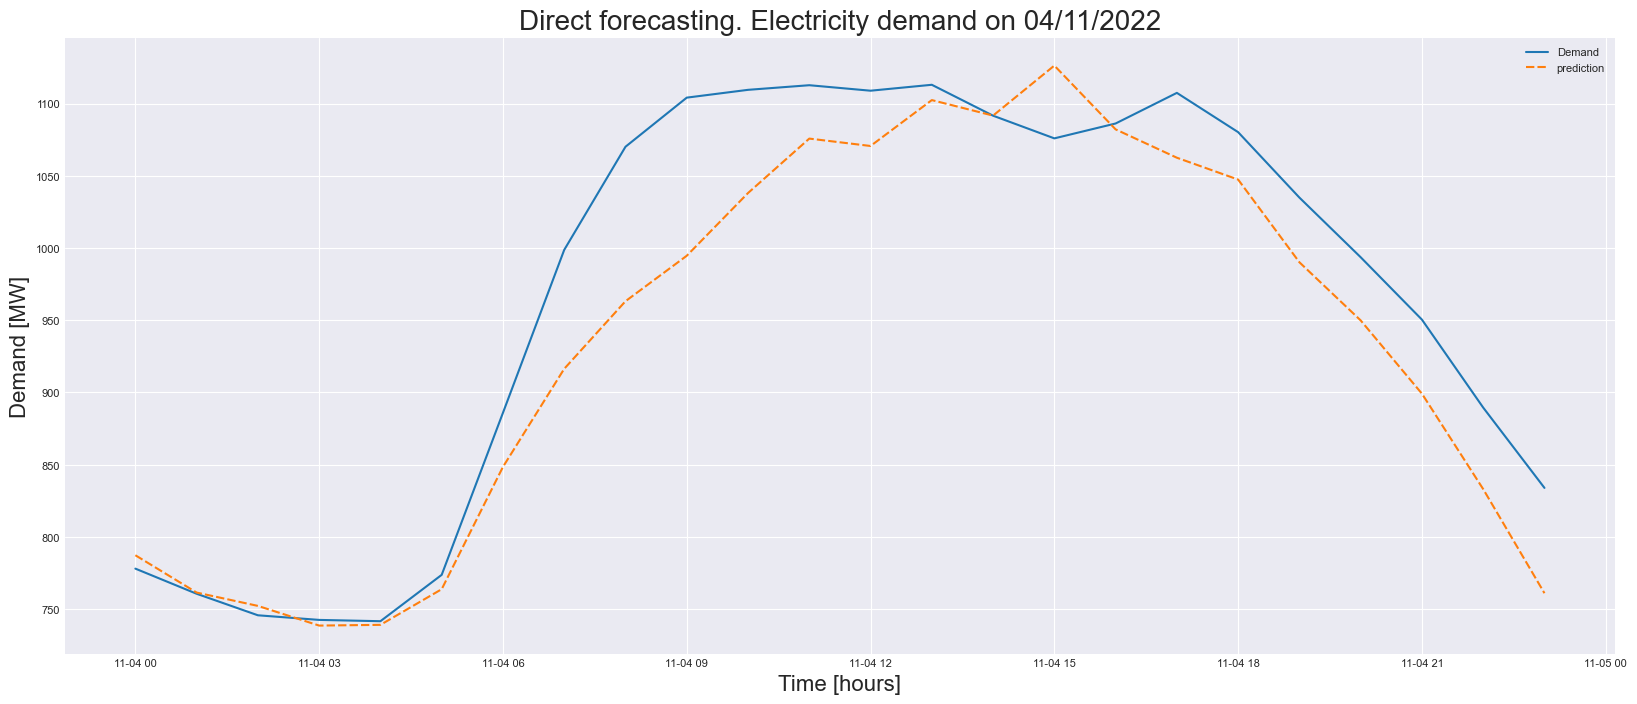

In [147]:
y_test = testing_vector[['Demand']]
y_test
predictions.set_index(y_test.index, inplace=True)
predictions = predictions.rename(columns = {0:'prediction'})

plt.figure(figsize=(20,8))
plt.title(predict_for_start.date())
p = sns.lineplot(data = y_test.join(predictions));
plt.title("Direct forecasting. Electricity demand on 04/11/2022", fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Demand [MW]", fontsize = 16);

print("MAPE: %.3f" % (mean_absolute_percentage_error(y_test, predictions)*100))

# Multi-step-ahead forecast. Recursive

In [160]:
recursive = data[['Demand','hour_day']].copy()
for x in range(1,25):
    cname = "lag_" + str(x)
    recursive[cname] = recursive['Demand'].shift(x)
recursive.tail(48)

,Demand,hour_day,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-12-30 00:00:00,876.8,0,919.6,977.8,1031.4,1077.0,1105.1,1142.3,1167.5,1175.1,...,1113.0,1080.3,995.0,924.7,870.7,821.5,819.8,827.3,850.6,885.9
2022-12-30 01:00:00,840.8,1,876.8,919.6,977.8,1031.4,1077.0,1105.1,1142.3,1167.5,...,1130.2,1113.0,1080.3,995.0,924.7,870.7,821.5,819.8,827.3,850.6
2022-12-30 02:00:00,824.1,2,840.8,876.8,919.6,977.8,1031.4,1077.0,1105.1,1142.3,...,1142.0,1130.2,1113.0,1080.3,995.0,924.7,870.7,821.5,819.8,827.3
2022-12-30 03:00:00,807.8,3,824.1,840.8,876.8,919.6,977.8,1031.4,1077.0,1105.1,...,1138.7,1142.0,1130.2,1113.0,1080.3,995.0,924.7,870.7,821.5,819.8
2022-12-30 04:00:00,802.5,4,807.8,824.1,840.8,876.8,919.6,977.8,1031.4,1077.0,...,1139.2,1138.7,1142.0,1130.2,1113.0,1080.3,995.0,924.7,870.7,821.5
2022-12-30 05:00:00,820.9,5,802.5,807.8,824.1,840.8,876.8,919.6,977.8,1031.4,...,1134.8,1139.2,1138.7,1142.0,1130.2,1113.0,1080.3,995.0,924.7,870.7
2022-12-30 06:00:00,874.2,6,820.9,802.5,807.8,824.1,840.8,876.8,919.6,977.8,...,1151.2,1134.8,1139.2,1138.7,1142.0,1130.2,1113.0,1080.3,995.0,924.7
2022-12-30 07:00:00,942.2,7,874.2,820.9,802.5,807.8,824.1,840.8,876.8,919.6,...,1175.1,1151.2,1134.8,1139.2,1138.7,1142.0,1130.2,1113.0,1080.3,995.0
2022-12-30 08:00:00,1018.6,8,942.2,874.2,820.9,802.5,807.8,824.1,840.8,876.8,...,1167.5,1175.1,1151.2,1134.8,1139.2,1138.7,1142.0,1130.2,1113.0,1080.3


In [171]:
predict_for_start = datetime.datetime(2022,11,4)
predict_for_end = predict_for_start + datetime.timedelta(days = 1)

training_end = predict_for_start - datetime.timedelta(days = 1)
training_start = training_end - datetime.timedelta(days = 30)

testing_vector = recursive[(recursive.index >= predict_for_start) &  (recursive.index < predict_for_end)]
training_vector = recursive[(recursive.index >= training_start) &  (recursive.index < training_end)]

,Demand,hour_day,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-10-04 00:00:00,747.7,0,792.1,878.0,950.3,1001.7,1026.0,1007.7,1024.5,1042.5,...,1065.0,1021.8,945.6,832.9,711.3,682.7,682.5,692.2,708.8,724.0
2022-10-04 01:00:00,728.5,1,747.7,792.1,878.0,950.3,1001.7,1026.0,1007.7,1024.5,...,1069.5,1065.0,1021.8,945.6,832.9,711.3,682.7,682.5,692.2,708.8
2022-10-04 02:00:00,716.2,2,728.5,747.7,792.1,878.0,950.3,1001.7,1026.0,1007.7,...,1068.1,1069.5,1065.0,1021.8,945.6,832.9,711.3,682.7,682.5,692.2
2022-10-04 03:00:00,711.1,3,716.2,728.5,747.7,792.1,878.0,950.3,1001.7,1026.0,...,1064.0,1068.1,1069.5,1065.0,1021.8,945.6,832.9,711.3,682.7,682.5
2022-10-04 04:00:00,708.7,4,711.1,716.2,728.5,747.7,792.1,878.0,950.3,1001.7,...,1048.5,1064.0,1068.1,1069.5,1065.0,1021.8,945.6,832.9,711.3,682.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-02 19:00:00,1036.6,19,1065.7,1086.8,1081.1,1095.2,1091.0,1115.5,1101.1,1119.3,...,730.4,729.8,734.7,738.0,766.4,807.0,875.5,944.3,992.1,1025.2
2022-11-02 20:00:00,999.1,20,1036.6,1065.7,1086.8,1081.1,1095.2,1091.0,1115.5,1101.1,...,766.0,730.4,729.8,734.7,738.0,766.4,807.0,875.5,944.3,992.1
2022-11-02 21:00:00,949.8,21,999.1,1036.6,1065.7,1086.8,1081.1,1095.2,1091.0,1115.5,...,884.8,766.0,730.4,729.8,734.7,738.0,766.4,807.0,875.5,944.3


In [172]:
X_train = training_vector.loc[:, ~training_vector .columns.isin(['hour_day', 'Demand'])]
y_train = training_vector[['Demand']]
X_train

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-10-04 00:00:00,792.1,878.0,950.3,1001.7,1026.0,1007.7,1024.5,1042.5,1032.7,1038.5,...,1065.0,1021.8,945.6,832.9,711.3,682.7,682.5,692.2,708.8,724.0
2022-10-04 01:00:00,747.7,792.1,878.0,950.3,1001.7,1026.0,1007.7,1024.5,1042.5,1032.7,...,1069.5,1065.0,1021.8,945.6,832.9,711.3,682.7,682.5,692.2,708.8
2022-10-04 02:00:00,728.5,747.7,792.1,878.0,950.3,1001.7,1026.0,1007.7,1024.5,1042.5,...,1068.1,1069.5,1065.0,1021.8,945.6,832.9,711.3,682.7,682.5,692.2
2022-10-04 03:00:00,716.2,728.5,747.7,792.1,878.0,950.3,1001.7,1026.0,1007.7,1024.5,...,1064.0,1068.1,1069.5,1065.0,1021.8,945.6,832.9,711.3,682.7,682.5
2022-10-04 04:00:00,711.1,716.2,728.5,747.7,792.1,878.0,950.3,1001.7,1026.0,1007.7,...,1048.5,1064.0,1068.1,1069.5,1065.0,1021.8,945.6,832.9,711.3,682.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-02 19:00:00,1065.7,1086.8,1081.1,1095.2,1091.0,1115.5,1101.1,1119.3,1113.2,1105.3,...,730.4,729.8,734.7,738.0,766.4,807.0,875.5,944.3,992.1,1025.2
2022-11-02 20:00:00,1036.6,1065.7,1086.8,1081.1,1095.2,1091.0,1115.5,1101.1,1119.3,1113.2,...,766.0,730.4,729.8,734.7,738.0,766.4,807.0,875.5,944.3,992.1
2022-11-02 21:00:00,999.1,1036.6,1065.7,1086.8,1081.1,1095.2,1091.0,1115.5,1101.1,1119.3,...,884.8,766.0,730.4,729.8,734.7,738.0,766.4,807.0,875.5,944.3


In [221]:
model = LinearRegression()
model.fit(X_train,y_train)

y_test = testing_vector[['Demand']]

X_test = testing_vector.loc[testing_vector.hour_day == 0]
X_test = X_test.loc[:, ~training_vector .columns.isin(['hour_day', 'Demand'])]

predictions = np.array([]) 

prediction =  pd.DataFrame(model.predict(X_test))
predictions = np.append(predictions, np.array([prediction[0][0]])) 

for h in range(1,24):
    prediction =  pd.DataFrame(model.predict(X_test))
    predictions = np.append(predictions, np.array([prediction[0][0]]))
    
    X_test = X_test.T.shift(1).copy()
    X_test = X_test.T
    X_test['lag_1'] = prediction[0][0]


MAPE: 3.939


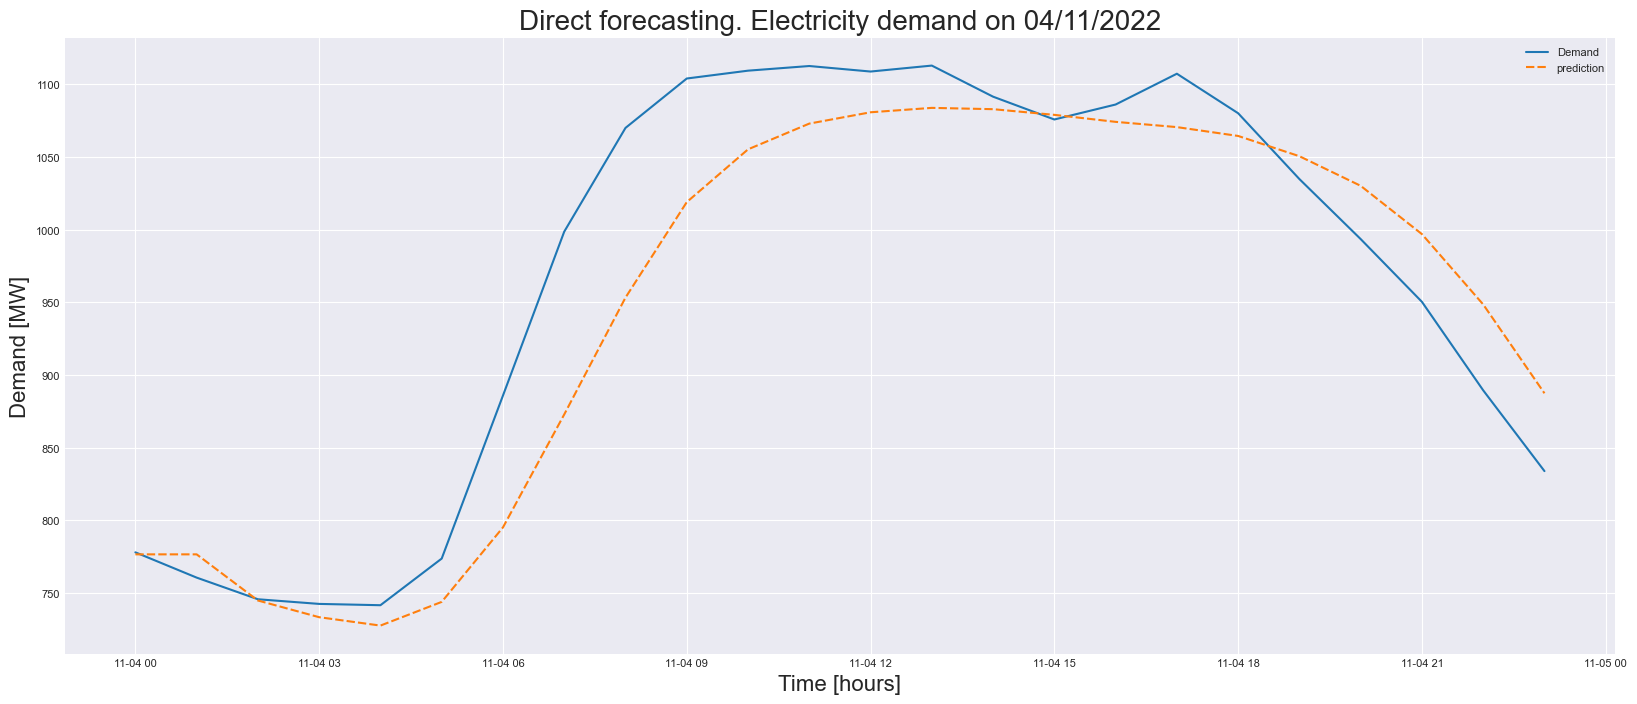

In [222]:
y_test = testing_vector[['Demand']]
y_test
predictions =  pd.DataFrame(predictions)

predictions.set_index(y_test.index, inplace=True)
predictions = predictions.rename(columns = {0:'prediction'})

plt.figure(figsize=(20,8))
plt.title(predict_for_start.date())
p = sns.lineplot(data = y_test.join(predictions));
plt.title("Direct forecasting. Electricity demand on 04/11/2022", fontsize = 20)
p.set_xlabel("Time [hours]", fontsize = 16);
p.set_ylabel("Demand [MW]", fontsize = 16);

print("MAPE: %.3f" % (mean_absolute_percentage_error(y_test, predictions)*100))


# Split

History      : 2022-09-01 00:00:00 --- 2022-10-02 23:00:00  (n=768)
Training dates : 2022-10-03 00:00:00 --- 2022-11-03 23:00:00  (n=768)
Test dates       : 2022-11-04 00:00:00 --- 2022-11-04 23:00:00  (n=24)


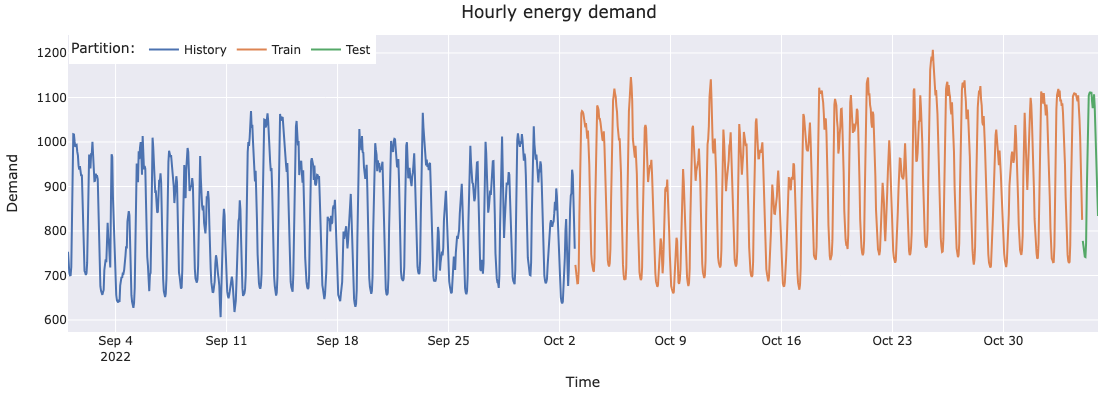

In [228]:
# Split data into train-val-test
# ==============================================================================
#data = data.loc['2022-01-01 00:00:00': '2022-12-31 23:00:00'].copy()
start_train = '2022-09-01 00:00:00'
end_train = '2022-10-02 23:59:00'
end_validation = '2022-11-03 23:59:00'
end_test = '2022-11-04 23:59:00'

data_train = data.loc[start_train: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:end_test, :].copy()

print(f"History      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Training dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['Demand'], mode='lines', name='History'))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val['Demand'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['Demand'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Hourly energy demand',
    xaxis_title="Time",
    yaxis_title="Demand",
    legend_title="Partition:",
    width=850,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()